# Import Libraries

In [1]:
# Import built-in Python libs
import pickle
from pathlib import Path
from dataclasses import dataclass
from typing import List
import unicodedata

# Import data science libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import weights & bias
import wandb

# Import deep learning libs
import torch
import pytorch_lightning as pl

# Import data preprocessing libs
from tokenizers import Tokenizer, normalizers, pre_tokenizers, decoders, NormalizedString, PreTokenizedString
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.normalizers import NFKC
from tokenizers.processors import TemplateProcessing
from torch.utils.data import Dataset, DataLoader
import fasttext
import jieba
from janome.tokenizer import Tokenizer as jTokenizer

---

# Split Raw Dataset to Source and Target datasets

In [4]:
root_dir = Path.cwd().parent
data_dir = root_dir / "dataset" / "ASPEC-JC"

def extract_jp_ch_datasets(txt_arr):
    p = np.array([list(map(str.strip, text.split("|||")[1:])) for text in txt_arr])
    jp = p[:, 0]
    ch = p[:, 1]
    return ch, jp


def split_raw_text(txt_path):
    with txt_path.open() as f:
        ch, jp = extract_jp_ch_datasets(f.readlines())
        
        np.savetxt(txt_path.parent / "ch.txt", ch, fmt="%s")
        np.savetxt(txt_path.parent / "jp.txt", jp, fmt="%s")


dev_txt = data_dir / "dev" / "dev.txt"
devtest_txt = data_dir / "devtest" / "devtest.txt"
test_txt = data_dir / "test" / "test.txt"
train_txt = data_dir / "train" / "train.txt"

# uncomment to run the split program
# split_raw_text(dev_txt)
# split_raw_text(devtest_txt)
# split_raw_text(test_txt)
# split_raw_text(train_txt)

## Log Raw Data Artifacts

In [4]:
run = wandb.init(project='phonetic-translation', 
                 entity='windsuzu',
                 group="dataset",
                 name="raw_data",
                 job_type="data_upload")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
# save raw txt file to artifact
#
# |-- train
#     |-- ch & jp
# |-- dev
#     |-- ch & jp
# |-- devtest
#     |-- ch & jp
# |-- test
#     |-- ch & jp

root_dir = Path.cwd().parent
data_dir = root_dir / "dataset" / "ASPEC-JC"
raw_data_types = ["train", "dev", "devtest", "test"]

artifacts = {}

for data_type in raw_data_types:
    artifacts[data_type] = wandb.Artifact(data_type, "raw_data")
    artifacts[data_type].add_file(data_dir / data_type / "ch.txt", "ch.txt")
    artifacts[data_type].add_file(data_dir / data_type / "jp.txt", "jp.txt")

for data_type, artifact in artifacts.items():
    run.log_artifact(artifact)

---
# Corpus Filtering

In [2]:
run = wandb.init(project='phonetic-translation', 
                 entity='windsuzu',
                 group="dataset",
                 job_type="corpus_filtering")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: windsuzu (use `wandb login --relogin` to force relogin)


In [5]:
# Download Raw Data
train_data_art = run.use_artifact("train:latest")
train_data_dir = train_data_art.download()

# Open Raw Data
with open(Path(train_data_dir) / "ch.txt", encoding="utf8") as f:
    ch_docs = f.readlines()

with open(Path(train_data_dir) / "jp.txt", encoding="utf8") as f:
    jp_docs = f.readlines()

wandb: Downloading large artifact train:latest, 205.64MB. 2 files... Done. 0:0:0


In [7]:
original_parallel_docs = list(zip(ch_docs, jp_docs))
len(original_parallel_docs)

672315

## Define Filtering Functions

In [8]:
PRETRAINED_MODEL_PATH = '../fasttext/lid.176.bin'
model = fasttext.load_model(PRETRAINED_MODEL_PATH)


def pass_length_ratio(ch, jp):
    l_r = len(ch) / len(jp)
    return l_r > 0.5 and l_r < 1.4


def pass_length(ch, jp):
    return len(ch) > 5 and len(ch) < 80 and len(jp) > 10 and len(jp) < 100


def pass_same_sentence(ch, jp):
    return ch != jp


def pass_language_identification(ch, jp):
    return model.predict(ch.strip())[0][0] == "__label__zh" and model.predict(jp.strip())[0][0] == "__label__ja"


def pass_imbalance_word(text):
    count = 0
    for c in text.strip():
        try:
            # find the difference between (ch+jp) and (en+num+space)
            if c.encode("ascii").isalpha() or c.isdigit() or c.isspace():
                count += 1
        except:
            pass
    
    actual = len(text) - count
    return actual > count

## Basic Corpus Filtering

1. Âà™Èô§Èï∑Â∫¶ÊØî‰æãÈÅéÂ§ßÁöÑÂè•Â≠ê
2. Âà™Èô§ÈÅéÁü≠ÊàñÈÅéÈï∑ÁöÑÂè•Â≠ê
3. Âà™Èô§‰∏ÄÊ®£ÁöÑÂè•Â≠ê
4. Âà™Èô§‰∏çËÉΩË¢´ fasttext identification model Ë™çÂá∫Ë™ûË®ÄÁöÑÂè•Â≠ê
5. Âà™Èô§Ëã±Êñá„ÄÅÊï∏Â≠óÁ¨¶ËôüÂ§öÊñº‰∏≠Êó•ÊñáÁöÑÂè•Â≠ê
6. Âà™Èô§ÊúâÂ§öÁ®ÆÂ∞çÊáâÁöÑÁøªË≠ØÁöÑÂè•Â≠ê


In [9]:
filtered = []
overlap = {}

for ch, jp in original_parallel_docs:
    # change full-width character to half-width
    ch = unicodedata.normalize("NFKC", ch)
    jp = unicodedata.normalize("NFKC", jp)
    
    if not pass_length_ratio(ch, jp):
        continue
    
    if not pass_length(ch, jp):
        continue
    
    if not pass_same_sentence(ch, jp):
        continue
    
    if not pass_language_identification(ch, jp):
        continue
    
    if not pass_imbalance_word(ch) or not pass_imbalance_word(jp):
        continue
    
    if overlap.get(ch) or overlap.get(jp):
        continue
    else:
        overlap[ch] = jp
        overlap[jp] = ch
        
    filtered.append((ch, jp))

len(filtered)

557685

## Word Alignment

### Step 1

ÊääÊâÄÊúâÁöÑ‰∏≠ÊñáÂíåÊó•ÊñáÂè•Â≠êÈÉΩÁî® jieba Âíå janome ÈÄ≤Ë°å tokenizationÔºå‰∏¶ÁµÑÂêàÊàêË¶Å‰∏üÈÄ≤ fast_align Ê®°ÂûãÁöÑÊ†ºÂºè„ÄÇ

In [13]:
janome = ja_tokenizer()
corpus = []

for ch, jp in filtered:
    ch_str_tokenized = " ".join(jieba.cut(ch[:-1]))
    jp_str_tokenized = " ".join(janome.tokenize(jp[:-1], wakati=True))
    line = f"{ch_str_tokenized} ||| {jp_str_tokenized}\n"
    corpus.append(line)

with open("corpus.zh-ja", 'w', encoding="utf8") as f:
    f.writelines(corpus)

### Step 2

Áî® fast_align Ë∑ëÂá∫ `forward.align` Âíå `reverse.align` Ë®àÁÆóÊØè‰∏ÄÂè•ÁöÑ word_alignment ÂàÜÊï∏„ÄÇ

`align` Êñá‰ª∂ÁöÑÊØè‰∏ÄË°åÊ†ºÂºèÁÇ∫: `alignment ||| score`

In [59]:
# ./fast_align -i corpus/corpus.zh-ja -d -o -v -s > corpus/forward.align
# ./fast_align -i corpus/corpus.zh-ja -d -o -v -s -r > corpus/reverse.align

with open("../fast_align/corpus/forward.align") as f:
    forward = list(map(lambda x: float(x.split(" ||| ")[1].strip()), f.readlines()))

with open("../fast_align/corpus/reverse.align") as f:
    reverse = list(map(lambda x: float(x.split(" ||| ")[1].strip()), f.readlines()))

### Step 3

Âà™Èô§Ê©üÁéáÂ∞èÊñº -160 ÁöÑÂè•Â≠ê (ÂÖ± 96703 Âè•)ÔºåÁõÆÁöÑ‰∏ªË¶ÅÊòØÈôç‰ΩéË≥áÊñôÈõÜÂ§ßÂ∞è„ÄÇ

(array([2.90000e+01, 3.54000e+03, 9.31340e+04, 2.87882e+05, 1.73100e+05]),
 array([-395.466   , -317.093915, -238.72183 , -160.349745,  -81.97766 ,
          -3.605575]),
 <BarContainer object of 5 artists>)

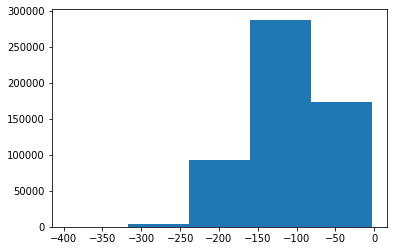

In [87]:
alignment_scores = [sum(score) / 2 for score in zip(forward, reverse)]
plt.hist(alignment_scores, bins=5)

# -3 ~ -81     173100
# -81 ~ -160   287882
#
# -160 ~ -238  93134
# -238 ~ -317  3540
# -317 ~ -395  29

In [90]:
final_filtered = []
for i, score in enumerate(alignment_scores):
    if score > -161:
        final_filtered.append(filtered[i])

In [134]:
len(final_filtered)

462582

In [4]:
root_dir = Path.cwd().parent
data_dir = root_dir / "dataset" / "ASPEC-JC"

ch = np.array(final_filtered)[:, 0]
jp = np.array(final_filtered)[:, 1]

np.savetxt(data_dir / "train" / "filtered_ch.txt", ch, fmt="%s", newline="", encoding="utf8")
np.savetxt(data_dir / "train" / "filtered_jp.txt", jp, fmt="%s", newline="", encoding="utf8")

## Log Filtered Data

In [5]:
filtered_artifact = wandb.Artifact("filtered_train", "filtered_data")

filtered_artifact.add_file(data_dir / "train" / "filtered_ch.txt", "ch.txt")
filtered_artifact.add_file(data_dir / "train" / "filtered_jp.txt", "jp.txt")

run.log_artifact(filtered_artifact)

---

# Tokenization Helpers

In [2]:
def train_tokenizer(
    tokenizer,
    files,
    unk_token="[UNK]",
    vocab_size=32000,
    min_frequency=2,
):
    trainer = BpeTrainer(
        special_tokens=[unk_token, "[BOS]", "[EOS]", "[PAD]"],
        vocab_size=vocab_size,
        show_prorgess=True,
        min_frequency=min_frequency,
    )

    if isinstance(files, str):
        files = [files]

    tokenizer.train(files, trainer=trainer)

In [3]:
def build_tokenizer(
    tokenizer,
    train_text_path: Path,
    min_frequency=2,
    padded=True,
    post_process=True,
):
    assert train_text_path.exists(), "Training Raw Text does not exist."

    # Train tokenizer
    train_tokenizer(tokenizer, str(train_text_path), min_frequency=min_frequency)

    # Enable Padding
    if padded:
        tokenizer.enable_padding(
            pad_id=tokenizer.token_to_id("[PAD]"), pad_token="[PAD]"
        )

    if post_process:
        # Encode => BOS + sentence + EOS
        tokenizer.post_processor = TemplateProcessing(
            single="[BOS] $A [EOS]",
            special_tokens=[
                ("[BOS]", tokenizer.token_to_id("[BOS]")),
                ("[EOS]", tokenizer.token_to_id("[EOS]")),
            ],
        )

    return tokenizer

In [4]:
def save_tokenzier(tokenizer, save_path, has_custom_norm=False, has_custom_pretok=False, has_custom_dec=False):
    if has_custom_norm:
        tokenizer.normalizer = normalizers.NFKC()
    
    if has_custom_pretok:
        tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    
    if has_custom_dec:
        tokenizer.decoder = decoders.WordPiece()
    
    tokenizer.save(str(save_path))
    
    
def load_tokenizer(tokenizer_path, custom_norm=None, custom_pretok=None, custom_dec=None):
    tokenizer = Tokenizer.from_file(str(tokenizer_path))
    if custom_norm:
        tokenizer.normalizer = custom_norm
    
    if custom_pretok:
        tokenizer.pre_tokenizer = custom_pretok
    
    if custom_dec:
        tokenizer.decoder = custom_dec
    
    return tokenizer

---

# Google Sentencepiece Tokenization

In [ ]:
run = wandb.init(project='phonetic-translation', 
                 entity='windsuzu',
                 group="tokenizer",
                 name="sentence_piece",
                 job_type="build_tokenizer")

In [ ]:
# Download Raw Data
train_data_art = run.use_artifact("filtered_train:latest")
train_data_dir = train_data_art.download()

In [8]:
def sentence_piece_tokenizer(unk_token="[UNK]", dropout: float = None):
    tokenizer = Tokenizer(BPE(dropout=dropout, unk_token=unk_token))
    tokenizer.normalizer = NFKC()
    tokenizer.pre_tokenizer = pre_tokenizers.Sequence(
        [
            pre_tokenizers.Whitespace(),
            pre_tokenizers.Punctuation(),
            pre_tokenizers.Digits(),
            pre_tokenizers.Metaspace(replacement="_", add_prefix_space=True),
        ]
    )

    tokenizer.decoder = decoders.Metaspace(replacement="_", add_prefix_space=True)
    return tokenizer

In [22]:
# Get Tokenizer.json File Path

root_dir = Path.cwd().parent
tokenizer_dir = root_dir / "tokenizer"
tokenizer_dir.mkdir(parents=True, exist_ok=True)

ch_tokenizer_dir = tokenizer_dir / "tokenizer_sentencepiece_ch.json"
jp_tokenizer_dir = tokenizer_dir / "tokenizer_sentencepiece_jp.json"

In [24]:
ch_tokenizer = build_tokenizer(
    sentence_piece_tokenizer(),
    Path(train_data_dir) / "ch.txt",
    min_frequency=2,
)

jp_tokenizer = build_tokenizer(
    sentence_piece_tokenizer(),
    Path(train_data_dir) / "jp.txt",
    min_frequency=2,
)

save_tokenzier(ch_tokenizer, ch_tokenizer_dir)
save_tokenzier(jp_tokenizer, jp_tokenizer_dir)

In [ ]:
ch_tokenizer = load_tokenizer(ch_tokenizer_dir)
jp_tokenizer = load_tokenizer(jp_tokenizer_dir)

In [25]:
# Print first ten vocab
print([(key, val) for key, val in ch_tokenizer.get_vocab().items()][:10])
print(ch_tokenizer.get_vocab_size())
print()

# Encode and Decode Testing
encoded = ch_tokenizer.encode("‰∏ªËåéÂèä1Ê¨°ÂàÜËòñÁ≤æÁ±≥ËõãÁôΩË¥®Âê´ÈáèÁöÑÊ†áÂáÜÂÅèÂ∑ÆÂ∞è,‰∏∫0.28~0.35%,2Ê¨°ÂàÜËòñÁöÑÊ†áÂáÜÂÅèÂ∑ÆÂ§ß,‰∏∫0.44~0.60%„ÄÇüòÄ")

print(encoded.ids)
print(encoded.tokens)
ch_tokenizer.decode(encoded.ids)

[('_ÁÆÄÊòì', 31689), ('AQ', 20138), ('DB', 9488), ('ÊúâÂèØËÉΩÊàê‰∏∫', 25035), ('ÊûùÊù°', 27143), ('_ÁöÑ‰∫∫', 23383), ('Âπª', 1599), ('ËøõË°åÂÆöÈáè', 14436), ('Áñ≤', 3075), ('Âú®ÊüêÁßçÁ®ãÂ∫¶‰∏ä', 22295)]
32000

[1, 7269, 3929, 895, 5379, 5674, 733, 4130, 3492, 3473, 6611, 13409, 11633, 1458, 5376, 5418, 5392, 5385, 7493, 6038, 5392, 5385, 7543, 5454, 5376, 5383, 5674, 733, 4130, 8674, 6887, 1276, 5376, 5418, 5392, 5385, 9376, 6038, 5392, 5385, 6655, 5454, 5377, 66, 0, 2]
['[BOS]', '_‰∏ª', 'Ëåé', 'Âèä', '_1', '_Ê¨°', 'ÂàÜ', 'Ëòñ', 'Á≤æ', 'Á±≥', 'ËõãÁôΩË¥®', 'Âê´ÈáèÁöÑ', 'Ê†áÂáÜÂÅèÂ∑Æ', 'Â∞è', '_,', '_‰∏∫', '_0', '_.', '_28', '_~', '_0', '_.', '_35', '_%', '_,', '_2', '_Ê¨°', 'ÂàÜ', 'Ëòñ', 'ÁöÑÊ†áÂáÜ', 'ÂÅèÂ∑Æ', 'Â§ß', '_,', '_‰∏∫', '_0', '_.', '_44', '_~', '_0', '_.', '_60', '_%', '_„ÄÇ', '_', '[UNK]', '[EOS]']


'‰∏ªËåéÂèä 1 Ê¨°ÂàÜËòñÁ≤æÁ±≥ËõãÁôΩË¥®Âê´ÈáèÁöÑÊ†áÂáÜÂÅèÂ∑ÆÂ∞è , ‰∏∫ 0 . 28 ~ 0 . 35 % , 2 Ê¨°ÂàÜËòñÁöÑÊ†áÂáÜÂÅèÂ∑ÆÂ§ß , ‰∏∫ 0 . 44 ~ 0 . 60 % „ÄÇ '

In [26]:
# Print first ten vocab
print([(key, val) for key, val in jp_tokenizer.get_vocab().items()][:10])
print(jp_tokenizer.get_vocab_size())
print()

# Encode and Decode Testing
encoded = jp_tokenizer.encode_batch(["Ôº£ÔºÜÔº§ÁÆ°ÁêÜÊñΩË®≠„ÅÆÈ´òÂ∫¶Âåñ", "üòÄÁï∞Ê•≠Á®Æ„Éç„ÉÉ„Éà„ÉØ„Éº„ÇØ„Åã„Çâ„ÅÆÂú∞Âüü„Éñ„É©„É≥„ÉâÂåñ"])

for i in range(2):
    print(encoded[i].ids)
    print(encoded[i].tokens)
    print(encoded[i].attention_mask)
    print(jp_tokenizer.decode(encoded[i].ids))
    print()

[('„É¢„Éê„Ç§„É´', 7803), ('Á≠â‰æ°„Å™', 26186), ('„Çµ„Éº„Éê„Å∏', 23005), ('Ê∏§', 2050), ('Ë´è', 3189), ('ÁôÇÊ≥ï„Å®', 26419), ('ÊÄß„ÅÆÂêë‰∏ä', 17113), ('‰∏ªÁúº', 26284), ('ÂèØËÉΩÊÄß„ÅåÈ´ò„ÅÑ', 9746), ('Â∫¶„ÇÑ', 26300)]
32000

[1, 3961, 6067, 4144, 4073, 5229, 26146, 716, 2, 3, 3, 3, 3]
['[BOS]', '_C', '_&', '_D', 'ÁÆ°ÁêÜ', 'ÊñΩË®≠', '„ÅÆÈ´òÂ∫¶', 'Âåñ', '[EOS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
C & DÁÆ°ÁêÜÊñΩË®≠„ÅÆÈ´òÂ∫¶Âåñ

[1, 63, 0, 9811, 1836, 2511, 4118, 4290, 4720, 361, 8074, 716, 2]
['[BOS]', '_', '[UNK]', '_Áï∞', 'Ê•≠', 'Á®Æ', '„Éç„ÉÉ„Éà„ÉØ„Éº„ÇØ', '„Åã„Çâ„ÅÆ', 'Âú∞Âüü', '„Éñ', '„É©„É≥„Éâ', 'Âåñ', '[EOS]']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 Áï∞Ê•≠Á®Æ„Éç„ÉÉ„Éà„ÉØ„Éº„ÇØ„Åã„Çâ„ÅÆÂú∞Âüü„Éñ„É©„É≥„ÉâÂåñ



## Log Tokenizer Artifact

In [132]:
artifact = wandb.Artifact("sentencepiece", 
                          type="tokenizer",
                          metadata={"vocab": 32000, 
                                    "method": "SentencePiece",
                                    "min_frequency": 2})

artifact.add_file(ch_tokenizer_dir, "ch_tokenizer.json")
artifact.add_file(jp_tokenizer_dir, "jp_tokenizer.json")
run.log_artifact(artifact)

# Language Specific Tokenization (Jieba & Janome)

In [8]:
run = wandb.init(project='phonetic-translation', 
                 entity='windsuzu',
                 group="tokenizer",
                 name="language_specific",
                 job_type="build_tokenizer")

wandb: Currently logged in as: windsuzu (use `wandb login --relogin` to force relogin)


In [9]:
# Download Raw Data
train_data_art = run.use_artifact("filtered_train:latest")
train_data_dir = train_data_art.download()

wandb: Downloading large artifact filtered_train:latest, 99.47MB. 2 files... Done. 0:0:0


In [10]:
# Get Tokenizer.json File Path

root_dir = Path.cwd().parent
tokenizer_dir = root_dir / "tokenizer"
tokenizer_dir.mkdir(parents=True, exist_ok=True)

jieba_tokenizer_dir = tokenizer_dir / "tokenizer_jieba.json"
janome_tokenizer_dir = tokenizer_dir / "tokenizer_janome.json"

## Jieba

In [9]:
class JiebaPreTokenizer:
    def jieba_split(self, i: int, normalized_string: NormalizedString) -> List[NormalizedString]:
        splits = []
        for token, start, stop in jieba.tokenize(str(normalized_string)):
            splits.append(normalized_string[start:stop])
        return splits
    
    def pre_tokenize(self, pretok: PreTokenizedString):
         pretok.split(self.jieba_split)
            
            
class JiebaDecoder:
    def decode(self, tokens: List[str]) -> str:
        return "".join(tokens)

In [10]:
def create_jieba_tokenizer(unk_token="[UNK]", dropout: float = None):
    tokenizer = Tokenizer(BPE(dropout=dropout, unk_token=unk_token))
    tokenizer.normalizer = NFKC()
    tokenizer.pre_tokenizer = pre_tokenizers.PreTokenizer.custom(JiebaPreTokenizer())
    tokenizer.decoder = decoders.Decoder.custom(JiebaDecoder())
    return tokenizer

In [41]:
jieba_tokenizer = build_tokenizer(
    create_jieba_tokenizer(),
    Path(train_data_dir) / "ch.txt",
    min_frequency=2,
)

save_tokenzier(jieba_tokenizer, jieba_tokenizer_dir, has_custom_pretok=True, has_custom_dec=True)

In [11]:
jieba_tokenizer = load_tokenizer(jieba_tokenizer_dir,
                                 custom_pretok=pre_tokenizers.PreTokenizer.custom(JiebaPreTokenizer()),
                                 custom_dec=decoders.Decoder.custom(JiebaDecoder()))

In [12]:
# Print first ten vocab
print([(key, val) for key, val in jieba_tokenizer.get_vocab().items()][:10])
print(jieba_tokenizer.get_vocab_size())
print()

# Encode and Decode Testing
encoded = jieba_tokenizer.encode_batch(["‰∏ªËåéÂèä1Ê¨°ÂàÜËòñÁ≤æÁ±≥ËõãÁôΩË¥®Âê´ÈáèÁöÑÊ†áÂáÜÂÅèÂ∑ÆÂ∞è,üòÄ", "‰∏∫0.28~0.35%,2Ê¨°ÂàÜËòñÁöÑÊ†áÂáÜÂÅèÂ∑ÆÂ§ß,‰∏∫0.44~0.60%„ÄÇ"])

for i in range(2):
    print(encoded[i].ids)
    print(encoded[i].tokens)
    print(encoded[i].attention_mask)
    print(jieba_tokenizer.decode(encoded[i].ids))
    print()

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


[('ËÅîÂêà‰ºö', 29267), ('ÁîüÂÑø', 26442), ('Ê∞∏‰πÖ', 13214), ('ÂÆπËÆ∏', 8355), ('J', 48), ('‰øÑ', 581), ('Âúè', 1158), ('ÂæÆÈáèÂÖÉÁ¥†', 12468), ('È¢¢', 5118), ('ÁôæÂàÜ‰πãÂá†', 28546)]
32000



Loading model cost 0.592 seconds.
Prefix dict has been built successfully.


[1, 17068, 898, 23, 2461, 20284, 3495, 3476, 6290, 6307, 3151, 8524, 1461, 18, 0, 2, 3, 3, 3, 3, 3, 3]
['[BOS]', '‰∏ªËåé', 'Âèä', '1', 'Ê¨°', 'ÂàÜËòñ', 'Á≤æ', 'Á±≥', 'ËõãÁôΩË¥®', 'Âê´Èáè', 'ÁöÑ', 'Ê†áÂáÜÂÅèÂ∑Æ', 'Â∞è', ',', '[UNK]', '[EOS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
‰∏ªËåéÂèä1Ê¨°ÂàÜËòñÁ≤æÁ±≥ËõãÁôΩË¥®Âê´ÈáèÁöÑÊ†áÂáÜÂÅèÂ∑ÆÂ∞è,

[1, 422, 30199, 100, 9866, 6213, 18, 24, 2461, 20284, 3151, 8524, 1279, 18, 422, 5543, 8890, 100, 5543, 8901, 228, 2]
['[BOS]', '‰∏∫', '0.28', '~', '0.3', '5%', ',', '2', 'Ê¨°', 'ÂàÜËòñ', 'ÁöÑ', 'Ê†áÂáÜÂÅèÂ∑Æ', 'Â§ß', ',', '‰∏∫', '0.', '44', '~', '0.', '60%', '„ÄÇ', '[EOS]']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
‰∏∫0.28~0.35%,2Ê¨°ÂàÜËòñÁöÑÊ†áÂáÜÂÅèÂ∑ÆÂ§ß,‰∏∫0.44~0.60%„ÄÇ




## Janome

In [14]:
ja_tokenizer = jTokenizer()
class JanomePreTokenizer:
    def janome_split(self, i: int, normalized_string: NormalizedString) -> List[NormalizedString]:
        splits = []
        i = 0
        for token in ja_tokenizer.tokenize(str(normalized_string), wakati=True):
            splits.append(normalized_string[i: i+len(token)])
            i += len(token)
        return splits
    
    def pre_tokenize(self, pretok: PreTokenizedString):
         pretok.split(self.janome_split)
            
            
class JanomeDecoder:
    def decode(self, tokens: List[str]) -> str:
        return "".join(tokens)

In [15]:
def create_janome_tokenizer(unk_token="[UNK]", dropout: float = None):
    tokenizer = Tokenizer(BPE(dropout=dropout, unk_token=unk_token))
    tokenizer.normalizer = NFKC()
    tokenizer.pre_tokenizer = pre_tokenizers.PreTokenizer.custom(JanomePreTokenizer())
    tokenizer.decoder = decoders.Decoder.custom(JanomeDecoder())
    return tokenizer

In [20]:
janome_tokenizer = build_tokenizer(
    create_janome_tokenizer(),
    Path(train_data_dir) / "jp.txt",
    min_frequency=2,
)

save_tokenzier(janome_tokenizer, janome_tokenizer_dir, has_custom_pretok=True, has_custom_dec=True)

Exception: Exception: KeyError: b'\xe7\x89\x88'

In [ ]:
janome_tokenizer = load_tokenizer(janome_tokenizer_dir,
                                 custom_pretok=pre_tokenizers.PreTokenizer.custom(JanomePreTokenizer()),
                                 custom_dec=decoders.Decoder.custom(JanomeDecoder()))

In [ ]:
# Print first ten vocab
print([(key, val) for key, val in janome_tokenizer.get_vocab().items()][:10])
print(janome_tokenizer.get_vocab_size())
print()

# Encode and Decode Testing
encoded = janome_tokenizer.encode_batch(["Ê®ôÊ∫ñÂÅèÂ∑Æ„ÅØ,‰∏ªËåé„Åä„Çà„Å≥1Ê¨°ÂàÜ„Åí„Å§„Åß0.28„Äú0.35%„Å®Â∞è„Åï„ÅèüòÄ", "2Ê¨°ÂàÜ„Åí„Å§„Åß0.44„Äú0.60%„Å®Â§ß„Åç„Åã„Å£„Åü„ÄÇ"])

for i in range(2):
    print(encoded[i].ids)
    print(encoded[i].tokens)
    print(encoded[i].attention_mask)
    print(janome_tokenizer.decode(encoded[i].ids))
    print()